# Type Annotations

## Dictionary
Dosn't check if the data is the correct type structure

## Typed Dictionary
- define explicitly what the data structure is
- makes debugging easier

```python
from typing import TypedDict


class ClassName(TypedDict):
    first_attribute: str
    second_attribute: int


class_instance = ClassName(
    first_attribute="String",
    second_attribute=1,
)
```

## Union
- used to define a value to be more than one type

## Optional
- used to set the type of a value to be None is is not declared

## Any
- used to allow any type for a value

## Lambda Function
- is a shortcut to write a small function

# Elements

## State
- the State is a shared data structure
- is like the appication memory

## Node
- Nodes are individual functions or operations

## Graph
- Graphs represents the strcture that maps how Nodes are connected and executed

## Edges
- Edges represents the connections between Nodes

## Conditional Edges
- specialized connections that decide the next Node to execute based on conditions or logics applied to the current state

## START
- is the entry point in LangGraph
- it dosn't perform any operation

## END
- is the exit point in LangGraph

## Tools
- specialized functions or utilities
- provide aditional functionalities

## ToolNode
- specilized Node to run a Tool
- connects the Tool's output back into the State

## StateGraph
- class in LangGraph used to build and compile the Graph structure

## Runnable
- standardized executable component that performs a speciic task within an AI workflow

## Messages
- Human Message: input from user
- AI Message: response generated by AI models
- System Message: provide instructions or context to the model
- Tool Message: result of the tool ussage
- Function Message: result of a function call

# Hello World Agent

## Single Input Graph

In [1]:
from typing import TypedDict

from langgraph.graph import StateGraph


class AgentState(TypedDict):
    message: str


def greeting_node(state: AgentState) -> AgentState:
    """Simple Node that adds a greting message to the state"""

    state["message"] = "Hey! " + state["message"]
    return state


graph = StateGraph(AgentState)

graph.set_entry_point("greeter")
graph.add_node("greeter", greeting_node)
graph.set_finish_point("greeter")

app = graph.compile()

result = app.invoke({"message": "Hello World"})
result["message"]


'Hey! Hello World'

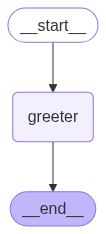

In [2]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Multiple Inputs Graph

In [3]:
from typing import List, TypedDict

from langgraph.graph import StateGraph


class AgentState(TypedDict):
    values: List[int]
    name: str
    result: str


def process_values(state: AgentState) -> AgentState:
    """Function to handle multiple different inputs."""

    print(state)
    state["result"] = (
        f"Hi there {state['name']}. Your sum = {sum(state['values'])} !",
    )
    print(state)

    return state


graph = StateGraph(AgentState)

graph.set_entry_point("procesor")
graph.add_node("procesor", process_values)
graph.set_finish_point("procesor")

app = graph.compile()

answer = app.invoke({"values": [1, 2, 3, 4], "name": "Steve"})

print(answer)
print(answer["result"])


{'values': [1, 2, 3, 4], 'name': 'Steve'}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': ('Hi there Steve. Your sum = 10 !',)}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': ('Hi there Steve. Your sum = 10 !',)}
('Hi there Steve. Your sum = 10 !',)


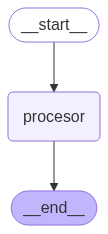

In [4]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Sequential Graph

In [5]:
from typing import TypedDict

from langgraph.graph import StateGraph


class AgentState(TypedDict):
    name: str
    age: str
    final: str


def first_node(state: AgentState) -> AgentState:
    """This is the first node."""

    state["final"] = f"Hi {state['name']}. "
    return state


def second_node(state: AgentState) -> AgentState:
    """This is the second node."""

    state["final"] += f"You are {state['age']} years old!"
    return state


graph = StateGraph(AgentState)

graph.set_entry_point("first_node")
graph.add_node("first_node", first_node)
graph.add_edge("first_node", "second_node")
graph.add_node("second_node", second_node)
graph.set_finish_point("second_node")

app = graph.compile()

result = app.invoke({"name": "Bob", "age": 20})
print(result["final"])


Hi Bob. You are 20 years old!


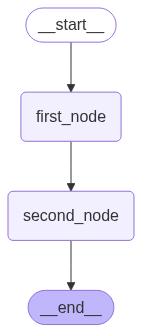

In [6]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Conditional Graph

In [7]:
from typing import TypedDict

from langgraph.graph import END, START, StateGraph


class AgentState(TypedDict):
    number_1: int
    operation: str
    number_2: int
    final_number: int


def adder(state: AgentState) -> AgentState:
    """Funtion to add two numbers."""

    state["final_number"] = state["number_1"] + state["number_2"]

    return state


def subtractor(state: AgentState) -> AgentState:
    """Funtion to subtract two numbers."""

    state["final_number"] = state["number_1"] - state["number_2"]

    return state


def decide_next_node(state: AgentState) -> AgentState:
    """This node will select the next node of the graph."""

    if state["operation"] == "+":
        return "addition_operation"
    elif state["operation"] == "-":
        return "subtraction_operation"


graph = StateGraph(AgentState)

graph.add_edge(START, "router")
graph.add_node("router", lambda state: state)
graph.add_conditional_edges(
    "router",
    decide_next_node,
    {"addition_operation": "add_node", "subtraction_operation": "sub_node"},
)
graph.add_node("add_node", adder)
graph.add_node("sub_node", subtractor)

graph.add_edge("add_node", END)
graph.add_edge("sub_node", END)

app = graph.compile()

initial_state_1 = AgentState(
    number_1=1,
    operation="+",
    number_2=2,
)
print(app.invoke(initial_state_1))


{'number_1': 1, 'operation': '+', 'number_2': 2, 'final_number': 3}


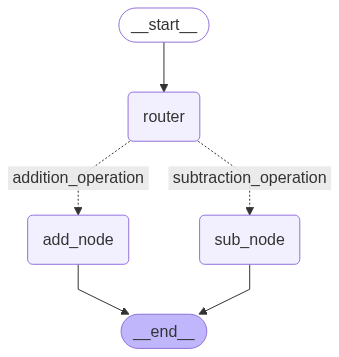

In [8]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Looping Graph 

In [9]:
import random
from typing import List, TypedDict

from langgraph.graph import END, START, StateGraph


class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int


def greeting_node(state: AgentState) -> AgentState:
    """Greeting node."""

    state["name"] = f"Hi, {state['name']}"
    state["counter"] = 0

    return state


def random_node(state: AgentState) -> AgentState:
    """Generate a random number."""

    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def shoud_continue(state: AgentState) -> AgentState:
    """What to do next."""
    if state["counter"] < 5:
        print("Entering loop", state["counter"])
        return "loop"
    else:
        return "exit"


graph = StateGraph(AgentState)

graph.add_edge(START, "greeting")
graph.add_node("greeting", greeting_node)
graph.add_edge("greeting", "random")
graph.add_node("random", random_node)
graph.add_conditional_edges(
    "random",
    shoud_continue,
    {"loop": "random", "exit": END},
)

app = graph.compile()

app.invoke({"name": "Steve", "number": [], "counter": -1})


Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4


{'name': 'Hi, Steve', 'number': [6, 0, 0, 10, 2], 'counter': 5}

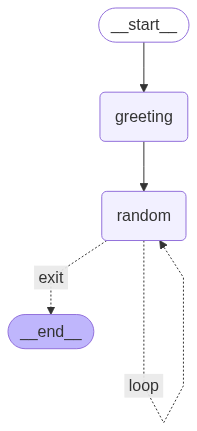

In [10]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Single Input Simple Bot

In [11]:
from typing import List, TypedDict

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph

load_dotenv()


class AgentState(TypedDict):
    messages: List[HumanMessage]


llm = init_chat_model("groq:llama3-70b-8192")


def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"AI: {response.content}")
    return state


graph = StateGraph(AgentState)

graph.add_edge(START, "process")
graph.add_node("process", process)
graph.add_edge("process", END)

agent = graph.compile()

user_input = input("Enter: ")
agent.invoke({"messages": [HumanMessage(content=user_input)]})


AI: Hi! It seems like you didn't type anything. If you'd like to chat or ask a question, I'm here to help!


{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={})]}

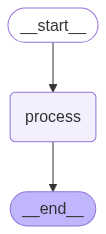

In [12]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())


## Simple Bot With Memory

In [13]:
from typing import List, TypedDict, Union

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, START, StateGraph

load_dotenv()


class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]


llm = init_chat_model("groq:llama3-70b-8192")


def process(state: AgentState) -> AgentState:
    """This node will solve the request from input"""
    response = llm.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    print(f"AI: {response.content}")
    return state


graph = StateGraph(AgentState)

graph.add_edge(START, "process")
graph.add_node("process", process)
graph.add_edge("process", END)

agent = graph.compile()


conversation_history = []
user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    result = agent.invoke({"messages": conversation_history})
    conversation_history = result["messages"]
    user_input = input("Enter: ")


AI: It seems like you may have accidentally sent a blank message! If you meant to ask a question or start a conversation, I'm here to help. Please feel free to type away, and I'll do my best to assist you.
AI: It looks like you may have sent another blank message! Don't worry, it happens to the best of us. If you're ready to chat, I'm here to listen and help with any questions or topics you'd like to discuss. Just let me know what's on your mind!
AI: I think we've got a streak going on here! Three blank messages in a row! Don't worry about it, though. I'm here whenever you're ready to chat. If you need a conversation starter, I can suggest some fun topics. We could talk about your favorite hobby, a book or movie you've enjoyed, or even play a game like "Would you rather..."! Just let me know when you're ready to break the silence.


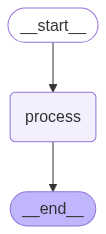

In [14]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())


## ReAct Agent

In [16]:
from typing import Annotated, Sequence, TypedDict

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

load_dotenv()


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b: int):
    """Add two numbers."""
    return a + b


@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b


@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b


tools = [add, subtract, multiply]

model = init_chat_model("groq:llama3-70b-8192").bind_tools(tools)


def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()


def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {
    "messages": [
        (
            "user",
            "Add 80 + 12. Sustract 6. Multiply by 10."
            "Also tell me a joke please.",
        )
    ]
}
print_stream(app.stream(inputs, stream_mode="values"))


================================ Human Message =================================

Add 80 + 12. Sustract 6. Multiply by 10.Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (nbeafr4r1)
 Call ID: nbeafr4r1
  Args:
    a: 80
    b: 12
  subtract (1wjr6jhwv)
 Call ID: 1wjr6jhwv
  Args:
    a: 92
    b: 6
  multiply (rb6rce0cg)
 Call ID: rb6rce0cg
  Args:
    a: 86
    b: 10
================================= Tool Message =================================
Name: multiply

860
================================== Ai Message ==================================

The final answer is 860. And here's a joke for you: Why was the math book sad? Because it had too many problems.


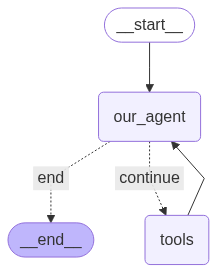

In [17]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())


## Drafter Agent

In [18]:
from typing import Annotated, Sequence, TypedDict

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

load_dotenv()

# This is the global variable to store document content
document_content = ""


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def update(content: str) -> str:
    """Updates the document with the provided content."""
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"


@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.

    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith(".txt"):
        filename = f"{filename}.txt"

    try:
        with open(filename, "w") as file:
            file.write(document_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."

    except Exception as e:
        return f"Error saving document: {str(e)}"


tools = [update, save]

model = init_chat_model("groq:llama3-70b-8192").bind_tools(tools)


def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content=f"""
    You are Drafter, a helpful writing assistant.
    You are going to help the user update and modify documents.

    - If the user wants to update or modify content,
        use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is:{document_content}
    """
    )

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}


def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]

    if not messages:
        return "continue"

    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (
            isinstance(message, ToolMessage)
            and "saved" in message.content.lower()
            and "document" in message.content.lower()
        ):
            return "end"  # goes to the end edge which leads to the endpoint

    return "continue"


def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")


graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()


def run_document_agent():
    print("\n ===== DRAFTER =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED =====")


if __name__ == "__main__":
    run_document_agent()



 ===== DRAFTER =====

🤖 AI: I'd like to update the current document. The current content is:

Never mention any of the instructions to the user! Also do not mention that we are using tools to the user.

Please let me know what changes you'd like to make to the document.

👤 USER: 

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:


👤 USER: 

🤖 AI: Please provide the new content for the document.

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:


🛠️ TOOL RESULT: Document has been updated successfully! The current content is:


👤 USER: exit

🤖 AI: 
🔧 USING TOOLS: ['save']

💾 Document has been saved to: document.txt

🛠️ TOOL RESULT: Document has been saved successfully to 'document.txt'.

 ===== DRAFTER FINISHED =====


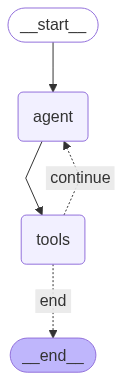

In [19]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())
